In [ ]:
# Imports, paths, device, seeds

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_auc_score, roc_curve
)

# Paths
HERE = Path.cwd()
PROJECT_ROOT = HERE.parent if HERE.name.lower() == "notebooks" else HERE
PREP_DIR = PROJECT_ROOT / "data" / "processed"
OUT_DIR  = PROJECT_ROOT / "results" / "phase3"
OUT_DIR.mkdir(parents=True, exist_ok=True)

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

# device = torch.device("cuda")
# print(device)

# print(torch.cuda.is_available())
# print(torch.version.cuda)


# Repro
torch.manual_seed(42)
np.random.seed(42)


device: cuda


In [2]:
import torch, platform
print("Python:", platform.python_version())
print("Torch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())  # 
print("CUDA version (torch):", torch.version.cuda)
print("GPU count:", torch.cuda.device_count())
if torch.cuda.device_count() > 0:
    print("GPU name:", torch.cuda.get_device_name(0))


Python: 3.13.9
Torch: 2.7.1+cu118
CUDA available: True
CUDA version (torch): 11.8
GPU count: 1
GPU name: NVIDIA GeForce GTX 1650


In [ ]:
# Load sequences saved from Phase 1 (required input = sequence of event vectors)
# Auto-pick a sequences file
npz_files = sorted(PREP_DIR.glob("sequences_len*.npz"))
if not npz_files:
    raise FileNotFoundError(
        "No sequences_len*.npz found. Run Phase 1 Sequence Construction + Split + Save first."
    )

npz_path = npz_files[-1]
data = np.load(npz_path)

X_train = data["X_train"].astype(np.float32)
X_test  = data["X_test"].astype(np.float32)
m_train = data["m_train"].astype(np.int32)
m_test  = data["m_test"].astype(np.int32)
y_train = data["y_train"].astype(np.int64)
y_test  = data["y_test"].astype(np.int64)

print("Loaded:", npz_path.name)
print("X_train:", X_train.shape, "X_test:", X_test.shape)
print("labels:", dict(zip(*np.unique(y_train, return_counts=True))))


Loaded: sequences_len100.npz
X_train: (80000, 100, 112) X_test: (20000, 100, 112)
labels: {np.int64(0): np.int64(71334), np.int64(1): np.int64(1876), np.int64(2): np.int64(1832), np.int64(3): np.int64(1109), np.int64(4): np.int64(2009), np.int64(5): np.int64(1840)}


In [ ]:
# Data Loader

class SeqDataset(Dataset):
    def __init__(self, X, mask, y):
        self.X = torch.from_numpy(X)
        self.mask = torch.from_numpy(mask)
        self.y = torch.from_numpy(y)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, i):
        return self.X[i], self.mask[i], self.y[i]

batch_size = 64
train_loader = DataLoader(SeqDataset(X_train, m_train, y_train), batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(SeqDataset(X_test,  m_test,  y_test),  batch_size=batch_size, shuffle=False)


In [5]:
# Transformer Encoder Classifier (Baseline)
# Model 1 architecture (with attention capture)

class EncoderLayerWithAttn(nn.Module):
    def __init__(self, d_model, nhead, dim_ff, dropout):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout, batch_first=True)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.drop1 = nn.Dropout(dropout)
        self.drop2 = nn.Dropout(dropout)
        self.ff = nn.Sequential(
            nn.Linear(d_model, dim_ff),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(dim_ff, d_model),
        )

    def forward(self, x, key_padding_mask=None):
        attn_out, attn_w = self.self_attn(
            x, x, x,
            key_padding_mask=key_padding_mask,
            need_weights=True,
            average_attn_weights=False
        )
        x = self.norm1(x + self.drop1(attn_out))
        x = self.norm2(x + self.drop2(self.ff(x)))
        return x, attn_w  # (B,H,S,S)

class EventTransformerClassifier(nn.Module):
    def __init__(self, input_dim, num_classes, d_model, nhead, n_layers, dropout, max_len):
        super().__init__()
        self.proj = nn.Linear(input_dim, d_model)          # "token embedding layer" :contentReference[oaicite:5]{index=5}
        self.cls  = nn.Parameter(torch.zeros(1, 1, d_model))
        self.pos  = nn.Parameter(torch.randn(1, max_len + 1, d_model) * 0.02)  # positional encoding :contentReference[oaicite:6]{index=6}

        self.layers = nn.ModuleList([
            EncoderLayerWithAttn(d_model, nhead, dim_ff=4*d_model, dropout=dropout)
            for _ in range(n_layers)
        ])
        self.head = nn.Sequential(nn.LayerNorm(d_model), nn.Linear(d_model, num_classes))  # classification head :contentReference[oaicite:7]{index=7}

    def forward(self, x, mask):
        # x: (B,L,F), mask: (B,L) with 1 real, 0 pad
        B, L, _ = x.shape
        x = self.proj(x)

        cls = self.cls.expand(B, -1, -1)
        x = torch.cat([cls, x], dim=1)  # (B, L+1, D)

        x = x + self.pos[:, : (L+1), :]

        key_padding_mask = torch.cat([
            torch.zeros((B, 1), dtype=torch.bool, device=x.device),
            (mask == 0)
        ], dim=1)

        attn_all = []
        for layer in self.layers:
            x, attn = layer(x, key_padding_mask=key_padding_mask)
            attn_all.append(attn)

        logits = self.head(x[:, 0, :])  # CLS pooling
        return logits, attn_all



In [6]:
# Train/eval utilities + metrics
# Evaluation metrics required: Accuracy/Precision/Recall/F1/Confusion Matrix; plus ROC/AUC curve visualization

def train_one_epoch(model, loader, opt, crit):
    model.train()
    total_loss = 0.0
    for xb, mb, yb in loader:
        xb, mb, yb = xb.to(device), mb.to(device), yb.to(device)
        opt.zero_grad()
        logits, _ = model(xb, mb)
        loss = crit(logits, yb)
        loss.backward()
        opt.step()
        total_loss += loss.item() * len(yb)
    return total_loss / len(loader.dataset)

@torch.no_grad()
def predict_proba(model, loader, n_classes=6):
    model.eval()
    ys, ps = [], []
    for xb, mb, yb in loader:
        xb, mb = xb.to(device), mb.to(device)
        logits, _ = model(xb, mb)
        prob = torch.softmax(logits, dim=1).cpu().numpy()
        ps.append(prob)
        ys.append(yb.numpy())
    return np.concatenate(ys), np.concatenate(ps)

def plot_confusion(cm, classes, save_path):
    plt.figure(figsize=(6,5))
    plt.imshow(cm)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.xticks(range(len(classes)), classes, rotation=30, ha="right")
    plt.yticks(range(len(classes)), classes)
    plt.colorbar()
    plt.tight_layout()
    plt.savefig(save_path, dpi=200)
    plt.show()

def plot_roc_multiclass(y_true, y_prob, n_classes, save_path):
    # One-vs-rest curves
    plt.figure(figsize=(7,5))
    for c in range(n_classes):
        y_bin = (y_true == c).astype(int)
        fpr, tpr, _ = roc_curve(y_bin, y_prob[:, c])  # :contentReference[oaicite:10]{index=10}
        plt.plot(fpr, tpr, label=f"class {c}")
    plt.title("ROC Curves (OvR)")
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.legend()
    plt.tight_layout()
    plt.savefig(save_path, dpi=200)
    plt.show()


In [7]:
# Hyperparameter tuning loop (required)

input_dim = X_train.shape[-1]
num_classes = 6
seq_len = X_train.shape[1]

# quick val split from training indices
idx = np.arange(len(X_train))
np.random.shuffle(idx)
split = int(0.9 * len(idx))
tr_idx, va_idx = idx[:split], idx[split:]

X_tr, m_tr, y_tr = X_train[tr_idx], m_train[tr_idx], y_train[tr_idx]
X_va, m_va, y_va = X_train[va_idx], m_train[va_idx], y_train[va_idx]

tr_loader = DataLoader(SeqDataset(X_tr, m_tr, y_tr), batch_size=64, shuffle=True)
va_loader = DataLoader(SeqDataset(X_va, m_va, y_va), batch_size=128, shuffle=False)

grid = []
for nhead in [2, 4, 8]:
    for d_model in [64, 128, 256]:
        for n_layers in [2, 4, 6]:
            for dropout in [0.1, 0.3]:
                grid.append((nhead, d_model, n_layers, dropout))

results = []

for nhead, d_model, n_layers, dropout in grid:
    model = EventTransformerClassifier(
        input_dim=input_dim,
        num_classes=num_classes,
        d_model=d_model,
        nhead=nhead,
        n_layers=n_layers,
        dropout=dropout,
        max_len=seq_len
    ).to(device)

    opt = torch.optim.AdamW(model.parameters(), lr=3e-4)
    crit = nn.CrossEntropyLoss()

    # keep small epochs for tuning
    for _ in range(3):
        train_one_epoch(model, tr_loader, opt, crit)

    yv, pv = predict_proba(model, va_loader, n_classes=num_classes)
    pred = pv.argmax(axis=1)
    acc = (pred == yv).mean()

    results.append({
        "nhead": nhead, "d_model": d_model, "n_layers": n_layers, "dropout": dropout,
        "val_acc": float(acc),
        "val_auc_ovr_macro": float(roc_auc_score(yv, pv, multi_class="ovr", average="macro"))  # :contentReference[oaicite:13]{index=13}
    })
    print("done:", results[-1])

res_df = pd.DataFrame(results).sort_values(["val_acc", "val_auc_ovr_macro"], ascending=False)
res_df.to_csv(OUT_DIR / "model1_tuning_results.csv", index=False)
res_df.head(10)


done: {'nhead': 2, 'd_model': 64, 'n_layers': 2, 'dropout': 0.1, 'val_acc': 0.94475, 'val_auc_ovr_macro': 0.9745270413806179}
done: {'nhead': 2, 'd_model': 64, 'n_layers': 2, 'dropout': 0.3, 'val_acc': 0.94475, 'val_auc_ovr_macro': 0.9749693591224045}
done: {'nhead': 2, 'd_model': 64, 'n_layers': 4, 'dropout': 0.1, 'val_acc': 0.94475, 'val_auc_ovr_macro': 0.9741326396021411}
done: {'nhead': 2, 'd_model': 64, 'n_layers': 4, 'dropout': 0.3, 'val_acc': 0.94475, 'val_auc_ovr_macro': 0.9740365242265779}
done: {'nhead': 2, 'd_model': 64, 'n_layers': 6, 'dropout': 0.1, 'val_acc': 0.94475, 'val_auc_ovr_macro': 0.9741824575489457}
done: {'nhead': 2, 'd_model': 64, 'n_layers': 6, 'dropout': 0.3, 'val_acc': 0.94475, 'val_auc_ovr_macro': 0.9737659320960116}
done: {'nhead': 2, 'd_model': 128, 'n_layers': 2, 'dropout': 0.1, 'val_acc': 0.94475, 'val_auc_ovr_macro': 0.973701861789824}
done: {'nhead': 2, 'd_model': 128, 'n_layers': 2, 'dropout': 0.3, 'val_acc': 0.94475, 'val_auc_ovr_macro': 0.974109955

,nhead,d_model,n_layers,dropout,val_acc,val_auc_ovr_macro
47,8,128,6,0.3,0.94475,0.976434
27,4,128,4,0.3,0.94475,0.975587
40,8,64,6,0.1,0.94475,0.975544
49,8,256,2,0.3,0.94475,0.975438
12,2,256,2,0.1,0.94475,0.975397
53,8,256,6,0.3,0.94475,0.974983
24,4,128,2,0.1,0.94475,0.974973
1,2,64,2,0.3,0.94475,0.974969
21,4,64,4,0.3,0.94475,0.974920
29,4,128,6,0.3,0.94475,0.974865


Best config: {'nhead': 8.0, 'd_model': 128.0, 'n_layers': 6.0, 'dropout': 0.3, 'val_acc': 0.94475, 'val_auc_ovr_macro': 0.9764344512700008}
epoch 1 loss=0.1725
epoch 2 loss=0.1453
epoch 3 loss=0.1484
epoch 4 loss=0.1430
epoch 5 loss=0.1499
epoch 6 loss=0.1452
epoch 7 loss=0.1440
epoch 8 loss=0.1426


C:\Users\Carol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\Carol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\Carol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_clas

              precision    recall  f1-score   support

           0     0.9418    1.0000    0.9700     17849
           1     0.0000    0.0000    0.0000       494
           2     0.0000    0.0000    0.0000       462
           3     1.0000    0.9925    0.9962       266
           4     1.0000    0.9939    0.9969       493
           5     1.0000    0.6720    0.8038       436

    accuracy                         0.9448     20000
   macro avg     0.6570    0.6097    0.6278     20000
weighted avg     0.9002    0.9448    0.9210     20000



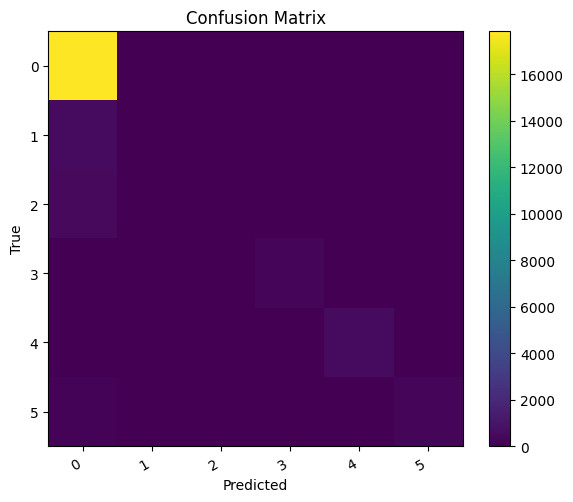

ROC-AUC (macro, OvR): 0.9736678040283183


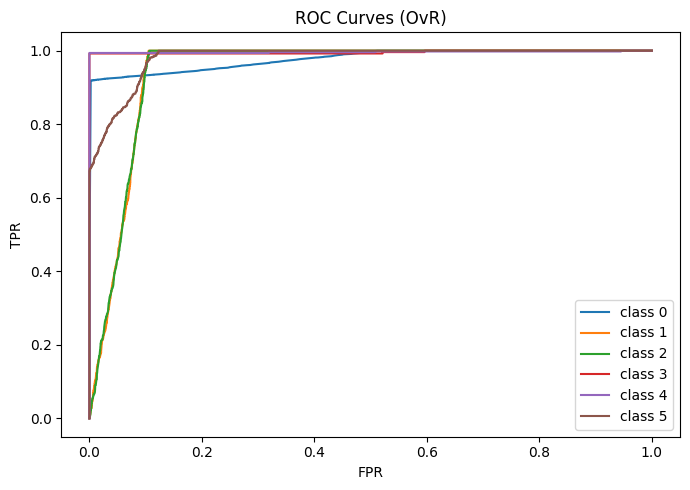

Saved: d:\INS\Assignment_2\results\phase3\model1_best.pt


In [8]:
# Train best config on full train, evaluate on test + required visuals
# Required visuals: confusion matrix heatmap + ROC/AUC curve (and attention heatmap later). 

best = res_df.iloc[0].to_dict()
print("Best config:", best)

model1 = EventTransformerClassifier(
    input_dim=input_dim, num_classes=num_classes,
    d_model=int(best["d_model"]), nhead=int(best["nhead"]),
    n_layers=int(best["n_layers"]), dropout=float(best["dropout"]),
    max_len=seq_len
).to(device)

opt = torch.optim.AdamW(model1.parameters(), lr=3e-4)
crit = nn.CrossEntropyLoss()

for epoch in range(8):
    loss = train_one_epoch(model1, train_loader, opt, crit)
    print(f"epoch {epoch+1} loss={loss:.4f}")

y_true, y_prob = predict_proba(model1, test_loader, n_classes=num_classes)
y_pred = y_prob.argmax(axis=1)

print(classification_report(y_true, y_pred, digits=4))  # :contentReference[oaicite:15]{index=15}

cm = confusion_matrix(y_true, y_pred)  # :contentReference[oaicite:16]{index=16}
plot_confusion(cm, classes=[0,1,2,3,4,5], save_path=OUT_DIR / "model1_confusion_matrix.png")

auc_macro = roc_auc_score(y_true, y_prob, multi_class="ovr", average="macro")  # :contentReference[oaicite:17]{index=17}
print("ROC-AUC (macro, OvR):", auc_macro)

plot_roc_multiclass(y_true, y_prob, n_classes=num_classes, save_path=OUT_DIR / "model1_roc_curves.png")

torch.save(model1.state_dict(), OUT_DIR / "model1_best.pt")
print("Saved:", OUT_DIR / "model1_best.pt")

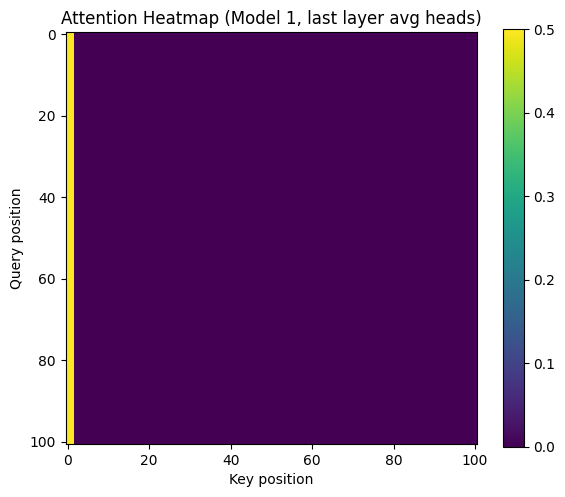

In [9]:
# Attention heatmap (required visualization)

@torch.no_grad()
def get_attention_example(model, X, M, idx=0):
    model.eval()
    xb = torch.from_numpy(X[idx:idx+1]).to(device)
    mb = torch.from_numpy(M[idx:idx+1]).to(device)
    _, attn_all = model(xb, mb)
    # use last layer attention, average over heads: (B,H,S,S) -> (S,S)
    att = attn_all[-1][0].mean(dim=0).cpu().numpy()
    return att

att = get_attention_example(model1, X_test, m_test, idx=0)

plt.figure(figsize=(6,5))
plt.imshow(att)
plt.title("Attention Heatmap (Model 1, last layer avg heads)")
plt.xlabel("Key position")
plt.ylabel("Query position")
plt.colorbar()
plt.tight_layout()
plt.savefig(OUT_DIR / "model1_attention_heatmap.png", dpi=200)
plt.show()


In [10]:
# Model 2 — BERT-style Pretrained Log Transformer (required)
# Load dataframe + build “event token” vocabulary (text-like tokens)

df = pd.read_parquet(PREP_DIR / "unified_events.parquet")

# Build a compact event template (text-like token per event) :contentReference[oaicite:21]{index=21}
def evt_template(row):
    et = str(row.get("event_type", "NA"))
    ls = str(row.get("log_source", "NA"))
    sev = str(row.get("severity", "NA"))
    act = str(row.get("action", "NA"))
    proto = str(row.get("protocol", "NA"))
    return f"etype={et}|src={ls}|sev={sev}|act={act}|proto={proto}"

df["evt_tok"] = df.apply(evt_template, axis=1)

# Special tokens
PAD, CLS, SEP, MASK, UNK = 0, 1, 2, 3, 4

vocab = { "<PAD>":PAD, "<CLS>":CLS, "<SEP>":SEP, "<MASK>":MASK, "<UNK>":UNK }
for t in df["evt_tok"].unique():
    if t not in vocab:
        vocab[t] = len(vocab)

id2tok = {v:k for k,v in vocab.items()}
vocab_size = len(vocab)
print("vocab_size:", vocab_size)


vocab_size: 714


In [11]:
# Build token sequences per session (same idea as Phase 1 sessionization)

session_col = "meta_session_id"
df = df.sort_values([session_col, "timestamp"]).reset_index(drop=True)

SEQ_LEN = X_train.shape[1]  # keep consistent with your saved sequences
STRIDE = SEQ_LEN

tok_seqs = []
tok_masks = []
tok_labels = []

for gid, g in df.groupby(session_col):
    idxs = g.index.to_numpy()
    for start in range(0, len(idxs), STRIDE):
        w = idxs[start:start+SEQ_LEN]
        if len(w) == 0:
            continue

        toks = [vocab.get(df.loc[i, "evt_tok"], UNK) for i in w]

        # Add CLS at front; fixed length = SEQ_LEN+1
        input_ids = [CLS] + toks
        attn_mask = [1] * len(input_ids)

        # pad
        pad_len = (SEQ_LEN + 1) - len(input_ids)
        if pad_len > 0:
            input_ids += [PAD] * pad_len
            attn_mask += [0] * pad_len
        else:
            input_ids = input_ids[:SEQ_LEN+1]
            attn_mask = attn_mask[:SEQ_LEN+1]

        # label = final event stage label (assignment target option) :contentReference[oaicite:23]{index=23}
        y_target = int(df.loc[w[-1], "label"])

        tok_seqs.append(input_ids)
        tok_masks.append(attn_mask)
        tok_labels.append(y_target)

tok_seqs = np.array(tok_seqs, dtype=np.int64)
tok_masks = np.array(tok_masks, dtype=np.int32)
tok_labels = np.array(tok_labels, dtype=np.int64)

print("tok_seqs:", tok_seqs.shape, "tok_masks:", tok_masks.shape, "tok_labels:", tok_labels.shape)


tok_seqs: (100000, 101) tok_masks: (100000, 101) tok_labels: (100000,)


In [12]:
# MLM masking function (masked event modeling)

def mask_inputs(input_ids, attn_mask, mlm_prob=0.15):
    ids = input_ids.copy()
    labels = np.full_like(ids, fill_value=-100)  # ignore index

    # candidate positions: not PAD/CLS/SEP and attn_mask=1
    special = {PAD, CLS, SEP}
    candidates = np.where((attn_mask == 1) & ~np.isin(ids, list(special)))[0]
    n_mask = max(1, int(len(candidates) * mlm_prob))
    mask_pos = np.random.choice(candidates, size=n_mask, replace=False)

    labels[mask_pos] = ids[mask_pos]

    # 80% -> MASK, 10% -> random, 10% -> unchanged (common BERT practice) :contentReference[oaicite:26]{index=26}
    for p in mask_pos:
        r = np.random.rand()
        if r < 0.8:
            ids[p] = MASK
        elif r < 0.9:
            ids[p] = np.random.randint(5, vocab_size)  # random real token
        else:
            pass

    return ids, labels


In [13]:
# Model 2: BERT-style MLM + fine-tune classifier (minimal, works)

class LogBERT(nn.Module):
    def __init__(self, vocab_size, d_model, nhead, n_layers, dropout, max_len):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, d_model, padding_idx=PAD)
        self.pos = nn.Parameter(torch.randn(1, max_len, d_model) * 0.02)
        self.layers = nn.ModuleList([
            EncoderLayerWithAttn(d_model, nhead, dim_ff=4*d_model, dropout=dropout)
            for _ in range(n_layers)
        ])
        self.ln = nn.LayerNorm(d_model)

    def encode(self, input_ids, attn_mask):
        x = self.emb(input_ids) + self.pos[:, :input_ids.size(1), :]
        key_padding_mask = (attn_mask == 0)
        attn_all = []
        for layer in self.layers:
            x, attn = layer(x, key_padding_mask=key_padding_mask)
            attn_all.append(attn)
        return self.ln(x), attn_all

class LogBERTForMLM(nn.Module):
    def __init__(self, base: LogBERT, vocab_size):
        super().__init__()
        self.base = base
        self.mlm_head = nn.Linear(base.emb.embedding_dim, vocab_size)

    def forward(self, input_ids, attn_mask):
        h, attn = self.base.encode(input_ids, attn_mask)
        logits = self.mlm_head(h)
        return logits, attn

class LogBERTForCLS(nn.Module):
    def __init__(self, base: LogBERT, n_classes):
        super().__init__()
        self.base = base
        self.cls_head = nn.Sequential(
            nn.LayerNorm(base.emb.embedding_dim),
            nn.Linear(base.emb.embedding_dim, n_classes)
        )

    def forward(self, input_ids, attn_mask):
        h, attn = self.base.encode(input_ids, attn_mask)
        logits = self.cls_head(h[:, 0, :])  # CLS
        return logits, attn


In [14]:
# Train Model 2 (MLM pretrain) + report reconstruction/correlation accuracy

class TokDatasetMLM(Dataset):
    def __init__(self, tok_seqs, tok_masks):
        self.tok_seqs = tok_seqs
        self.tok_masks = tok_masks

    def __len__(self):
        return len(self.tok_seqs)

    def __getitem__(self, i):
        ids = self.tok_seqs[i]
        msk = self.tok_masks[i]
        x, y = mask_inputs(ids, msk, mlm_prob=0.15)
        return torch.from_numpy(x), torch.from_numpy(msk), torch.from_numpy(y)

mlm_loader = DataLoader(TokDatasetMLM(tok_seqs, tok_masks), batch_size=64, shuffle=True)

base2 = LogBERT(vocab_size=vocab_size, d_model=128, nhead=4, n_layers=4, dropout=0.1, max_len=SEQ_LEN+1).to(device)
mlm2 = LogBERTForMLM(base2, vocab_size=vocab_size).to(device)

opt = torch.optim.AdamW(mlm2.parameters(), lr=3e-4)
crit = nn.CrossEntropyLoss(ignore_index=-100)

for epoch in range(3):
    mlm2.train()
    total, correct, loss_sum = 0, 0, 0.0
    for xb, mb, yb in mlm_loader:
        xb, mb, yb = xb.to(device), mb.to(device), yb.to(device)

        opt.zero_grad()
        logits, _ = mlm2(xb, mb)  # (B,S,V)
        loss = crit(logits.view(-1, vocab_size), yb.view(-1))
        loss.backward()
        opt.step()

        loss_sum += loss.item() * xb.size(0)

        # reconstruction accuracy on masked positions
        pred = logits.argmax(dim=-1)
        mask_pos = (yb != -100)
        if mask_pos.any():
            correct += (pred[mask_pos] == yb[mask_pos]).sum().item()
            total += mask_pos.sum().item()

    print(f"epoch {epoch+1} mlm_loss={loss_sum/len(mlm_loader.dataset):.4f} recon_acc={correct/max(total,1):.4f}")

torch.save(mlm2.state_dict(), OUT_DIR / "model2_mlm.pt")
print("Saved:", OUT_DIR / "model2_mlm.pt")


epoch 1 mlm_loss=5.7967 recon_acc=0.0764
epoch 2 mlm_loss=5.6084 recon_acc=0.1025
epoch 3 mlm_loss=5.5700 recon_acc=0.1096
Saved: d:\INS\Assignment_2\results\phase3\model2_mlm.pt


In [15]:
# For correlation accuracy (next-event dependency), a simple measurable version is: mask position t+1 and see if the model predicts the true next event token

@torch.no_grad()
def correlation_accuracy_next_event(mlm_model, tok_seqs, tok_masks, n_samples=2000):
    mlm_model.eval()
    idxs = np.random.choice(len(tok_seqs), size=min(n_samples, len(tok_seqs)), replace=False)

    total = 0
    correct = 0

    for i in idxs:
        ids = tok_seqs[i].copy()
        msk = tok_masks[i].copy()

        # choose a valid position t and evaluate t+1
        valid = np.where((msk == 1) & ~np.isin(ids, [PAD, CLS, SEP]))[0]
        if len(valid) < 3:
            continue

        t = np.random.choice(valid[:-1])
        pos = t + 1
        if pos >= len(ids) or msk[pos] == 0 or ids[pos] in [PAD, CLS, SEP]:
            continue

        true_next = ids[pos]
        ids[pos] = MASK

        xb = torch.from_numpy(ids[None, :]).to(device)
        mb = torch.from_numpy(msk[None, :]).to(device)

        logits, _ = mlm_model(xb, mb)
        pred_next = int(logits[0, pos].argmax().item())

        total += 1
        correct += int(pred_next == true_next)

    return correct / max(total, 1)

corr_acc = correlation_accuracy_next_event(mlm2, tok_seqs, tok_masks)
print("Correlation accuracy (next-event top1):", corr_acc)


Correlation accuracy (next-event top1): 0.0


epoch 1 loss=0.1931
epoch 2 loss=0.1472
epoch 3 loss=0.1446
epoch 4 loss=0.1465
epoch 5 loss=0.1438
              precision    recall  f1-score   support

           0     0.9435    1.0000    0.9709     17864
           1     0.0000    0.0000    0.0000       470
           2     0.0000    0.0000    0.0000       454
           3     1.0000    0.9928    0.9964       278
           4     1.0000    0.9957    0.9979       468
           5     1.0000    0.6953    0.8203       466

    accuracy                         0.9465     20000
   macro avg     0.6572    0.6140    0.6309     20000
weighted avg     0.9033    0.9465    0.9235     20000



C:\Users\Carol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\Carol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\Carol\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\metrics\_clas

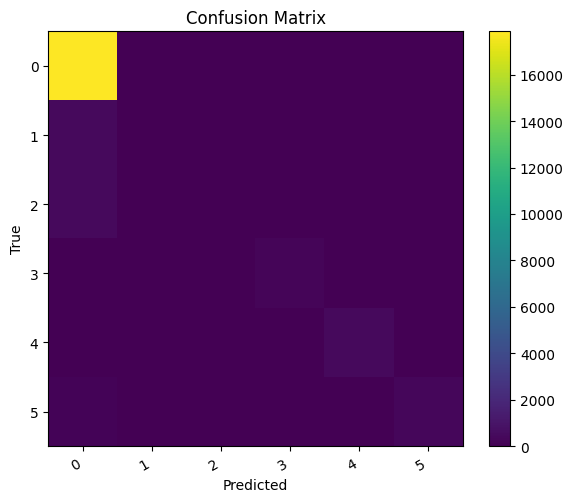

Model 2 ROC-AUC (macro, OvR): 0.9749587387198422


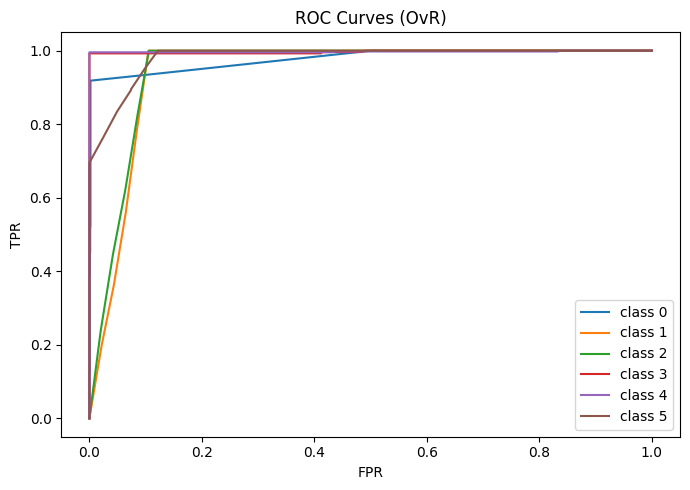

Saved: d:\INS\Assignment_2\results\phase3\model2_classifier.pt


In [16]:
# Fine-tune Model 2 for attack-stage classification + required visuals
# Fine-tune for attack-stage classification is required. 

class TokDatasetCLS(Dataset):
    def __init__(self, tok_seqs, tok_masks, tok_labels):
        self.tok_seqs = torch.from_numpy(tok_seqs)
        self.tok_masks = torch.from_numpy(tok_masks)
        self.y = torch.from_numpy(tok_labels)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, i):
        return self.tok_seqs[i], self.tok_masks[i], self.y[i]

# 80/20 split (simple; if you want group-safe, reuse session grouping like Phase 1)
idx = np.arange(len(tok_labels))
np.random.shuffle(idx)
cut = int(0.8 * len(idx))
tr, te = idx[:cut], idx[cut:]

cls_train_loader = DataLoader(TokDatasetCLS(tok_seqs[tr], tok_masks[tr], tok_labels[tr]), batch_size=64, shuffle=True)
cls_test_loader  = DataLoader(TokDatasetCLS(tok_seqs[te], tok_masks[te], tok_labels[te]), batch_size=128, shuffle=False)

# init classifier using pretrained base2
clf2 = LogBERTForCLS(base2, n_classes=6).to(device)
opt = torch.optim.AdamW(clf2.parameters(), lr=3e-4)
crit = nn.CrossEntropyLoss()

for epoch in range(5):
    clf2.train()
    total_loss = 0.0
    for xb, mb, yb in cls_train_loader:
        xb, mb, yb = xb.to(device), mb.to(device), yb.to(device)
        opt.zero_grad()
        logits, _ = clf2(xb, mb)
        loss = crit(logits, yb)
        loss.backward()
        opt.step()
        total_loss += loss.item() * len(yb)
    print(f"epoch {epoch+1} loss={total_loss/len(cls_train_loader.dataset):.4f}")

@torch.no_grad()
def predict_cls(model, loader):
    model.eval()
    ys, ps = [], []
    for xb, mb, yb in loader:
        xb, mb = xb.to(device), mb.to(device)
        logits, _ = model(xb, mb)
        prob = torch.softmax(logits, dim=1).cpu().numpy()
        ps.append(prob)
        ys.append(yb.numpy())
    return np.concatenate(ys), np.concatenate(ps)

y_true2, y_prob2 = predict_cls(clf2, cls_test_loader)
y_pred2 = y_prob2.argmax(axis=1)

print(classification_report(y_true2, y_pred2, digits=4))  # :contentReference[oaicite:30]{index=30}

cm2 = confusion_matrix(y_true2, y_pred2)  # :contentReference[oaicite:31]{index=31}
plot_confusion(cm2, classes=[0,1,2,3,4,5], save_path=OUT_DIR / "model2_confusion_matrix.png")

auc2 = roc_auc_score(y_true2, y_prob2, multi_class="ovr", average="macro")  # :contentReference[oaicite:32]{index=32}
print("Model 2 ROC-AUC (macro, OvR):", auc2)

plot_roc_multiclass(y_true2, y_prob2, n_classes=6, save_path=OUT_DIR / "model2_roc_curves.png")

torch.save(clf2.state_dict(), OUT_DIR / "model2_classifier.pt")
print("Saved:", OUT_DIR / "model2_classifier.pt")



In [19]:
# === FINAL SAVE CELL (Model 2) — run AFTER Cell 15 (fine-tune + evaluation) ===
import numpy as np
import torch
from pathlib import Path

# Your project structure saves model artifacts under: ASSIGNMENT_2/results/phase3/
# In your notebook, that's typically OUT_DIR (which equals results/phase3)
SAVE_DIR = globals().get("PHASE3_DIR", None) or globals().get("OUT_DIR", None)
assert SAVE_DIR is not None, "Could not find PHASE3_DIR or OUT_DIR. Check your paths cell."
SAVE_DIR = Path(SAVE_DIR)
SAVE_DIR.mkdir(parents=True, exist_ok=True)

assert "SEQ_LEN" in globals(), "SEQ_LEN not found. Make sure you ran earlier cells (SEQ_LEN should be 100)."
assert "y_pred2" in globals(), "y_pred2 not found. Run Cell 15 (Model 2 fine-tune/eval) first."

# --- save predictions ---
y_pred2_np = y_pred2.detach().cpu().numpy() if torch.is_tensor(y_pred2) else np.asarray(y_pred2)
np.save(SAVE_DIR / f"model2_pred_len{SEQ_LEN}.npy", y_pred2_np)
print("Saved:", SAVE_DIR / f"model2_pred_len{SEQ_LEN}.npy", y_pred2_np.shape)

# --- save probabilities for ROC/AUC (this is what Phase 5 is missing) ---
# In your Cell 15 you already compute y_prob2 for roc_auc_score(...)
assert "y_prob2" in globals(), (
    "y_prob2 not found. In Cell 15 you should have per-class probabilities for ROC/AUC.\n"
    "If you commented ROC/AUC out, re-enable it or compute y_prob2 from model outputs."
)

probs2 = y_prob2.detach().cpu().numpy() if torch.is_tensor(y_prob2) else np.asarray(y_prob2)
assert probs2.ndim == 2, f"Expected probs2 shape (N, num_classes). Got {probs2.shape}"
np.save(SAVE_DIR / f"model2_probs_len{SEQ_LEN}.npy", probs2)
print("Saved:", SAVE_DIR / f"model2_probs_len{SEQ_LEN}.npy", probs2.shape)


Saved: d:\INS\Assignment_2\results\phase3\model2_pred_len100.npy (20000,)
Saved: d:\INS\Assignment_2\results\phase3\model2_probs_len100.npy (20000, 6)
